# Tuning a scikit-learn estimator with `skopt`

Gilles Louppe, July 2016 <br />
Katie Malone, August 2016

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

## Problem statement

Tuning the hyper-parameters of a machine learning model is often carried out using an exhaustive exploration of (a subset of) the space all hyper-parameter configurations (e.g., using `sklearn.model_selection.GridSearchCV`), which often results in a very time consuming operation. 

In this notebook, we illustrate how to couple `gp_minimize` with sklearn's estimators to tune hyper-parameters using sequential model-based optimisation, hopefully resulting in equivalent or better solutions, but within less evaluations. 

Note: scikit-optimize provides a dedicated interface for estimator tuning via `BayesSearchCV` class which has a similar interface to those of `GridSearchCV`. This class uses functions of skopt to perform hyperparameter search efficiently. For example usage of this class, see "Scikit Learn HPO Wrapper" example notebook.

## Objective 

The first step is to define the objective function we want to minimize, in this case the cross-validation mean absolute error of a gradient boosting regressor over the Boston dataset, as a function of its hyper-parameters:

In [2]:
from sklearn.datasets import load_boston
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import cross_val_score

boston = load_boston()
X, y = boston.data, boston.target
n_features = X.shape[1]

reg = GradientBoostingRegressor(n_estimators=50, random_state=0)

def objective(params):
    max_depth, learning_rate, max_features, min_samples_split, min_samples_leaf = params

    reg.set_params(max_depth=max_depth,
                   learning_rate=learning_rate,
                   max_features=max_features,
                   min_samples_split=min_samples_split, 
                   min_samples_leaf=min_samples_leaf)

    return -np.mean(cross_val_score(reg, X, y, cv=5, n_jobs=-1,
                                    scoring="neg_mean_absolute_error"))

Next, we need to define the bounds of the dimensions of the search space we want to explore:

In [3]:
space  = [(1, 5),                           # max_depth
          (10**-5, 10**0, "log-uniform"),   # learning_rate
          (1, n_features),                  # max_features
          (2, 100),                         # min_samples_split
          (1, 100)]                         # min_samples_leaf

## Optimize all the things!

With these two pieces, we are now ready for sequential model-based optimisation. Here we use gaussian process-based optimisation.

In [4]:
from skopt import gp_minimize
res_gp = gp_minimize(objective, space, n_calls=100, random_state=0)

"Best score=%.4f" % res_gp.fun

'Best score=2.8239'

In [5]:
print("""Best parameters:
- max_depth=%d
- learning_rate=%.6f
- max_features=%d
- min_samples_split=%d
- min_samples_leaf=%d""" % (res_gp.x[0], res_gp.x[1], 
                            res_gp.x[2], res_gp.x[3], 
                            res_gp.x[4]))

Best parameters:
- max_depth=3
- learning_rate=0.112659
- max_features=9
- min_samples_split=34
- min_samples_leaf=1


## Convergence plot

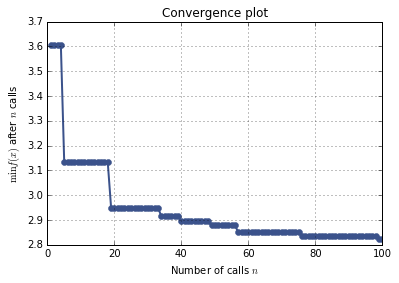

In [6]:
from skopt.plots import plot_convergence

plot_convergence(res_gp);